In [13]:
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt
import random

dat = pd.read_csv("./input/Prelim2019_RegularSeasonDetailedResults.csv") 
team_key = pd.read_csv("./input/Teams.csv")[["TeamID", "TeamName"]]

dat = dat[dat.Season == 2019].reset_index(drop = True)

dat['homei'] = np.where(dat.WLoc == "H", 1 , 0)
dat['homej'] = np.where(dat.WLoc == "A", 1 , 0)

dat['margin'] = dat.WScore - dat.LScore

dat = dat[["Season", "DayNum", "WTeamID", "WScore", "LTeamID", "LScore", "margin", "homei", "homej"]]
dat = dat.rename(columns={'WTeamID' : 'teami',
                          'WScore'  : 'scorei', 
                          'LTeamID' : 'teamj', 
                          'LScore'  : 'scorej',
                          'DayNum'  : 'daynum',
                          'Season'  : 'season'})

dat["gameid"] = np.where(dat['teami'] < dat['teamj'], 
                         dat['teami'].astype(str) + "_" + dat['teamj'].astype(str), 
                         dat['teamj'].astype(str) + "_" + dat['teami'].astype(str))

team_key["id"] = range(1, len(team_key.index) + 1)

dat = dat.merge(team_key, left_on="teami" , right_on="TeamID")
dat = dat.drop(columns=["TeamName", "teami", "TeamID"])
dat = dat.rename(index = str, columns = {"id" : "teami"})
dat = dat.merge(team_key, left_on="teamj" , right_on="TeamID")
dat = dat.drop(columns=["TeamName", "teamj", "TeamID"])
dat = dat.rename(index = str, columns = {"id" : "teamj"})

names = ["N", "y", "h_i", "h_j", "team_i", "team_j", "N_g"]
values = [len(dat.index), dat.margin, dat.homei, dat.homej, dat.teami, dat.teamj, 366]

train = dict(zip(names, values))

In [14]:
model = """
data {
    int N;
    vector[N] y;
    int team_i[N];
    int team_j[N];
    int h_i[N];
    int h_j[N];
    int N_g;
}
parameters {
    vector[N_g] alpha_raw;
    vector[N_g] theta_raw;
    real eta;
    real<lower=0> tau_theta;
    real<lower=0> tau_alpha;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N_g] alpha;
    vector[N_g] theta;
    alpha = eta + alpha_raw*tau_alpha;
    theta = theta_raw*tau_theta;
}
model {
    // vector for conditional mean storage
    vector[N] mu;

    // priors
    tau_theta ~ cauchy(0,1)T[0,];
    tau_alpha ~ cauchy(0,.25)T[0,];
    sigma ~ cauchy(0,1)T[0,];
    eta ~ normal(4,1);
    theta_raw ~ normal(0,1);
    alpha_raw ~ normal(0,1);

    // define mu for the Gaussian
    for( t in 1:N ) {
    mu[t] = (theta[team_i[t]] + alpha[team_i[t]]*h_i[t]) - 
    (theta[team_j[t]] + alpha[team_j[t]]*h_j[t]);
}

    // the likelihood
    y ~ normal(mu,sigma);
}
"""

sm = pystan.StanModel(model_code = model)
fit = sm.sampling(data = train, 
                  iter = 1500, 
                  warmup = 750,
                  refresh = 100,
                  control = dict(adapt_delta = 0.9))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa965bddd3ff659f18d82172fce2b1d5 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Text(0, 0.5, 'Teams')

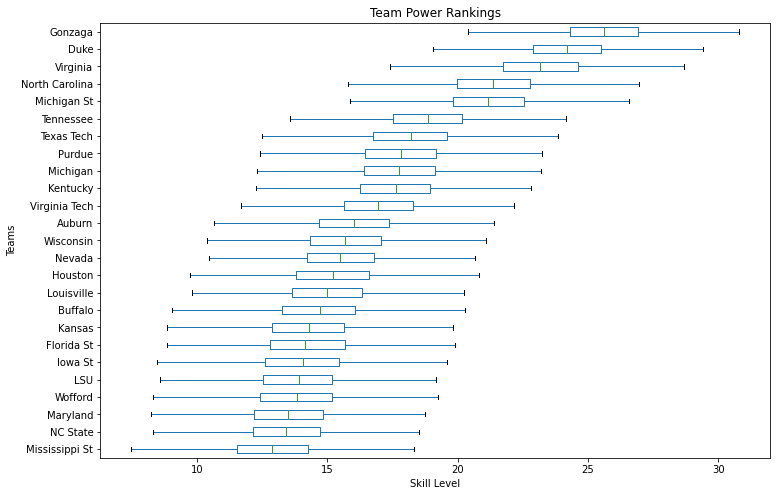

In [15]:
theta = pd.DataFrame(fit.extract()["theta"])
alpha = pd.DataFrame(fit.extract()["alpha"])
sigma = fit.extract()["sigma"]
alpha.columns = team_key.TeamName
theta.columns = team_key.TeamName

theta25 = theta[theta.median().nlargest(25).index]
theta25 = theta25[theta25.columns[::-1]]

theta25.boxplot(grid = False, vert = False, showfliers = False, figsize=(12, 8))
plt.title('Team Power Rankings')
plt.xlabel('Skill Level')
plt.ylabel('Teams')

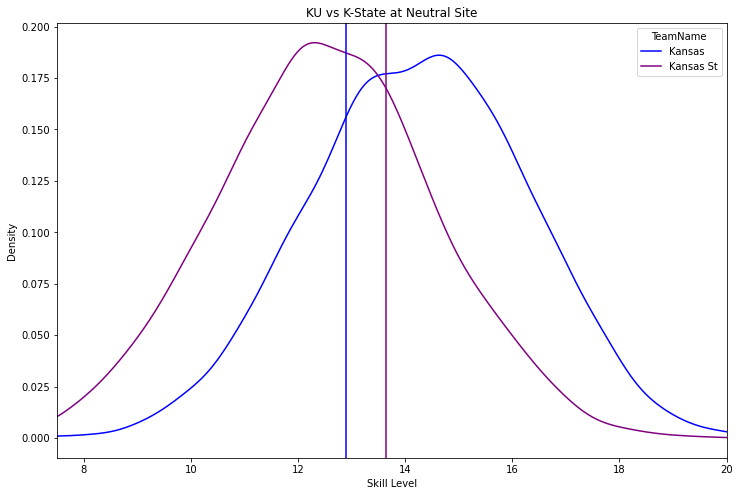

In [16]:
random.seed(6)

theta[["Kansas" , "Kansas St"]].plot(kind='density', 
                                     color = ["blue", "purple"], 
                                     figsize=(12, 8))
plt.title('KU vs K-State at Neutral Site')
plt.xlabel('Skill Level')
plt.xlim([7.5, 20])

plt.axvline(theta["Kansas"][random.randrange(len(theta["Kansas"]))], color = "blue")
plt.axvline(theta["Kansas St"][random.randrange(len(theta["Kansas St"]))], color = "purple")

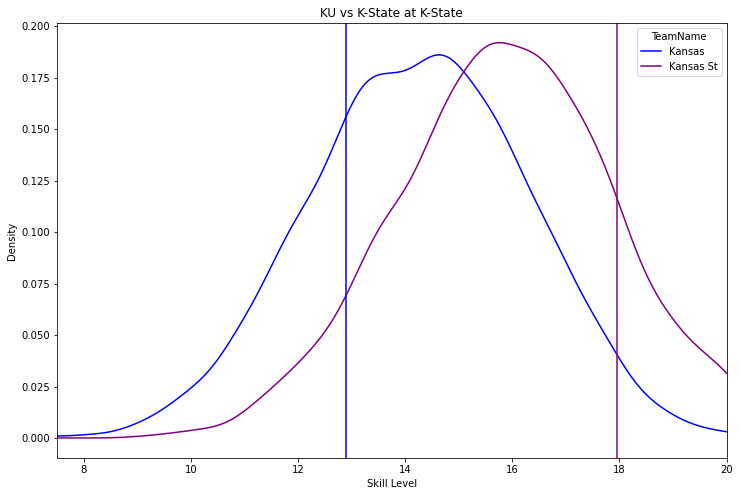

In [17]:
random.seed(6)

ftheta = theta.copy()
ftheta["Kansas St"] = ftheta["Kansas St"] + alpha["Kansas St"]

ftheta[["Kansas" , "Kansas St"]].plot(kind='density', 
                                     color = ["blue", "purple"],
                                     figsize=(12, 8))
plt.title('KU vs K-State at K-State')
plt.xlabel('Skill Level')
plt.xlim([7.5, 20])

plt.axvline(ftheta["Kansas"][random.randrange(len(ftheta["Kansas"]))], color = "blue")
plt.axvline(ftheta["Kansas St"][random.randrange(len(ftheta["Kansas St"]))], color = "purple")

In [18]:
random.seed(1985)

def compare(i, j, th= theta, a = alpha, sig = sigma, homei = 0, homej = 0, reps = 1000):
    win_prob = []
    for r in range(1, reps):
        win_prob.append(
            np.mean(
                th[i] - th[j] +
                a[i]*homei - a[j]*homej +
                np.random.normal(0, 
                                 sig[random.randrange(len(sig))], 
                                 len(th.index)
                ) > 0
            )
        )
    
    win_prob = np.mean(win_prob)
    
    print(i + " has a " + str(round(win_prob*100, 2)) + "% chance of beating " + j)
    
compare("Virginia", "Texas Tech")

Virginia has a 67.28% chance of beating Texas Tech


In [19]:
games = pd.DataFrame(np.array([['Play in',  "N Dakota St", "NC Central",   0, 0, .68],
                               ['Play in',  "Arizona St",  "St John's",    0, 1, .53],
                               ['Play in',  "F Dickinson", "Prairie View", 0, 0, .55],
                               ['Play in',  "Belmont",     "Temple",       0, 0, .58],
                               
                               ['Rd 64',    "Duke",           "N Dakota St",     1, 0, 1.0], 
                               ['Rd 64',    "Virginia",       "Gardner Webb",    0, 0, .98], 
                               ['Rd 64',    "Gonzaga",        "F Dickinson",     1, 0, .99], 
                               ['Rd 64',    "North Carolina", "Iona",            0, 0, .98], 
                               ['Rd 64',    "Michigan St",    "Bradley",         0, 0, .96], 
                               ['Rd 64',    "Kentucky",       "Abilene Chr",     1, 0, .97], 
                               ['Rd 64',    "Tennessee",      "Colgate",         0, 0, .95], 
                               ['Rd 64',    "Michigan",       "Montana",         1, 0, .94], 
                               ['Rd 64',    "Texas Tech",     "N Kentucky",      0, 0, .91], 
                               ['Rd 64',    "Purdue",         "Old Dominion",    0, 0, .88], 
                               ['Rd 64',    "Virginia Tech",  "St Louis",        0, 1, .89], 
                               ['Rd 64',    "Auburn",         "New Mexico St",   0, 1, .77], 
                               ['Rd 64',    "Florida",        "Nevada",          0, 0, .42], 
                               ['Rd 64',    "Florida St",     "Vermont",         0, 1, .79], 
                               ['Rd 64',    "Ohio St",        "Iowa St",         0, 0, .33], 
                               ['Rd 64',    "Villanova",      "St Mary's CA",    1, 0, .75], 
                               ['Rd 64',    "LSU",            "Yale",            0, 0, .84], 
                               ['Rd 64',    "Oklahoma",       "Mississippi",     0, 0, .53], 
                               ['Rd 64',    "Oregon",         "Wisconsin",       1, 0, .40], 
                               ['Rd 64',    "UC Irvine",      "Kansas St",       1, 0, .23], 
                               ['Rd 64',    "Iowa",           "Cincinnati",      0, 0, .32], 
                               ['Rd 64',    "Washington",     "Utah St",         0, 1, .49], 
                               ['Rd 64',    "Kansas",         "Northeastern",    1, 0, .83], 
                               ['Rd 64',    "Houston",        "Georgia St",      0, 0, .89], 
                               ['Rd 64',    "Wofford",        "Seton Hall",      0, 0, .63], 
                               ['Rd 64',    "Buffalo",        "Arizona St",      0, 0, .66], 
                               ['Rd 64',    "Murray St",      "Marquette",       0, 0, .36], 
                               ['Rd 64',    "Baylor",         "Syracuse",        1, 0, .40], 
                               ['Rd 64',    "Minnesota",      "Louisville",      0, 0, .32], 
                               ['Rd 64',    "Maryland",       "Belmont",         0, 0, .62], 
                               ['Rd 64',    "UCF",            "VA Commonwealth", 0, 0, .50], 
                               ['Rd 64',    "Liberty",        "Mississippi St",  0, 0, .21], 
                               
                               ['Rd 32',    "Duke",           "UCF",        0, 0, .91], 
                               ['Rd 32',    "Virginia Tech",  "Liberty",    0, 0, .86], 
                               ['Rd 32',    "LSU",            "Maryland",   0, 0, .56], 
                               ['Rd 32',    "Michigan St",     "Minnesota", 0, 0, .83], 
                               ['Rd 32',    "Gonzaga",        "Baylor",     0, 0, .91], 
                               ['Rd 32',    "Florida St",     "Murray St",  0, 0, .70], 
                               ['Rd 32',    "Texas Tech",     "Buffalo",    1, 0, .67], 
                               ['Rd 32',    "Michigan",       "Florida",    1, 0, .76], 
                               ['Rd 32',    "North Carolina", "Washington", 1, 0, .87], 
                               ['Rd 32',    "Auburn",         "Kansas",     0, 1, .56], 
                               ['Rd 32',    "Houston",        "Ohio St",    0, 0, .72], 
                               ['Rd 32',    "Kentucky",       "Wofford",    0, 0, .72], 
                               ['Rd 32',    "Tennessee",      "Iowa",       0, 0, .80], 
                               ['Rd 32',    "Purdue",         "Villanova",  0, 0, .53], 
                               ['Rd 32',    "Oregon",         "UC Irvine",  0, 0, .69], 
                               ['Rd 32',    "Virginia",       "Oklahoma",   0, 0, .88], 
                               
                               ["Sweet 16", "Duke",        "Virginia Tech",  0, 0, .75],
                               ["Sweet 16", "Michigan St", "LSU",            0, 0, .74],
                               ["Sweet 16", "Gonzaga",     "Florida St",     1, 0, .74],
                               ["Sweet 16", "Texas Tech",  "Michigan",       1, 0, .51],
                               ["Sweet 16", "Auburn",      "North Carolina", 0, 0, .38],
                               ["Sweet 16", "Kentucky",    "Houston",        0, 0, .56],
                               ["Sweet 16", "Purdue",      "Tennessee",      0, 0, .49],
                               ["Sweet 16", "Virginia",    "Oregon",         1, 0, .87],
                               
                               ["Elite 8",  "Auburn",      "Kentucky", 0, 0, .37],
                               ["Elite 8",  "Michigan St", "Duke",     0, 0, .33],
                               ["Elite 8",  "Virginia",    "Purdue",   0, 0, .64],
                               ["Elite 8",  "Texas Tech",  "Gonzaga",  0, 0, .37],
                               
                               ["Final 4",  "Texas Tech", "Michigan St", 0, 0, .46],
                               ["Final 4",  "Virginia",   "Auburn",      0, 0, .73]]),
                               columns = ['Round', 'Winner', 'Loser', 'Winhome', 'Losehome', 'FiveThirtyEight'])

def compare2(i, j, th= theta, a = alpha, sig = sigma, homei = 0, homej = 0, reps = 1000):
    win_prob = []
    for r in range(1, reps):
        win_prob.append(
            np.mean(
                th[i] - th[j] +
                a[i]*homei - a[j]*homej +
                np.random.normal(0, 
                                 sig[random.randrange(len(sig))], 
                                 len(th.index)
                ) > 0
            )
        )
    
    win_prob = np.mean(win_prob)
    return(win_prob)

preds = []

for g in range(len(games.index)):
    preds.append(compare2(games["Winner"][g], 
                          games["Loser"][g], 
                          homei = int(games["Winhome"][g]), 
                          homej = int(games["Losehome"][g])))
games["mine"] = preds

print("Our Mean Absolute Error is " + str(round(1 - np.mean(games["mine"]), 5)))
print("FiveThirtyEight's Mean Absolute Error is " + str(round(1 - np.mean(pd.to_numeric(games["FiveThirtyEight"])), 5)))

Our Mean Absolute Error is 0.33129
FiveThirtyEight's Mean Absolute Error is 0.33348


In [20]:
pd.set_option('display.max_rows', 500)
games[["Round", "Winner", "Loser", "FiveThirtyEight", "mine"]]

,Round,Winner,Loser,FiveThirtyEight,mine
0,Play in,N Dakota St,NC Central,0.68,0.695533
1,Play in,Arizona St,St John's,0.53,0.411278
2,Play in,F Dickinson,Prairie View,0.55,0.521484
3,Play in,Belmont,Temple,0.58,0.609520
4,Rd 64,Duke,N Dakota St,1.0,0.996764
5,Rd 64,Virginia,Gardner Webb,0.98,0.983436
6,Rd 64,Gonzaga,F Dickinson,0.99,0.998235
7,Rd 64,North Carolina,Iona,0.98,0.984685
8,Rd 64,Michigan St,Bradley,0.96,0.973501
9,Rd 64,Kentucky,Abilene Chr,0.97,0.966171
